In [1]:
#def get_obs_id_from_h5dl1_file(h5dl1InName):
#"/dl1/event/telescope/parameters/tel_001"
#col name is obs_id
#print(h5file)
#print(table)
#print(table[:]['energy'])
#print("for node in h5file")
#for node in h5file:
#print(node)
#h5file = open_file(h5dl1InName, "a")
#table = h5file.root.dl1.event.telescope.parameters.tel_001
#obs_id=int(np.mean(table[:]['obs_id']))
#obs_id_std=np.std(table[:]['obs_id'])
#print(obs_id)
#print(np.std(table[:]['obs_id']))
#h5file.close()
#if (obs_id_std == 0.0) :
#return obs_id
#return -999
#
import pandas as pd
import numpy as np
import glob
import gc
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.coordinates import SkyCoord, AltAz, angular_separation
import astropy.units as u
from scipy.stats import binned_statistic
from scipy.signal import lombscargle
import h5py
from astropy.io import fits
from astropy.table import Table
from tables import open_file

from astropy.table import join, vstack
from ctapipe.io import read_table 

from ctapipe.instrument import SubarrayDescription
from matplotlib.colors import LogNorm


import math

In [2]:
math.atan2(0.0,0.0)*180.0/np.pi

0.0

In [3]:
# Function to calculate phi
def get_phi_from_mpi_to_pi_true(row):
    return math.atan2(row['true_core_x'],row['true_core_y'])

In [4]:
# Function to calculate phi
def get_phi_from_mpi_to_pi_reco(row):
    return math.atan2(row['muonefficiency_impact_x'],row['muonefficiency_impact_y'])

In [5]:
# Function to calculate phi
def get_phi_from_mpi_to_pi_reco_rot(row):
    return math.atan2(row['muonefficiency_impact_x_rot'],row['muonefficiency_impact_y_rot'])

In [6]:
file_list = [f"data_not_fixed_chord_length/dl1_muon_ctapipe_run00{i}.h5" for i in np.arange(0,10)]
#file_list = [f"data_fixed_chord_length/dl1_muon_ctapipe_run00{i}.h5" for i in np.arange(0,10)]
#file_list = [f"data_fixed_chord_length_fixed_hole_radius/dl1_muon_ctapipe_run00{i}.h5" for i in np.arange(0,10)]
#file_list = [f"data_camera_shadowing_avet/dl1_muon_ctapipe_run00{i}.h5" for i in np.arange(0,10)]
#file_list = [f"data_camera_shadowing/dl1_muon_ctapipe_run00{i}.h5" for i in np.arange(0,10)]
#file_list

In [7]:
h5file_list = [open_file(filen, "a") for filen in file_list]
#h5file_list[0]

In [8]:
df_table_true_info_list = [pd.DataFrame(h5file_list[i].root.simulation.event.subarray.shower[:]) for i in np.arange(0,10)]
#df_table_true_info_list[0]

In [9]:
df_table_reco_mu_list = [pd.DataFrame(h5file_list[i].root.dl1.event.telescope.muon.tel_001[:]) for i in np.arange(0,10)]
#df_table_reco_mu_list[0]

In [10]:
df_table_true_info = pd.concat(df_table_true_info_list, ignore_index=True)

In [11]:
df_table_reco_mu = pd.concat(df_table_reco_mu_list, ignore_index=True)

In [12]:
df_table_reco_mu = df_table_reco_mu.rename(columns={"obs_id": "obs_id_reco"})

In [13]:
df_table_reco_mu = df_table_reco_mu.rename(columns={"event_id": "event_id_reco"})

In [14]:
print(len(df_table_true_info))
print(len(df_table_reco_mu))

99868
99868


In [15]:
print(df_table_true_info.keys())
print(df_table_reco_mu.keys())

Index(['obs_id', 'event_id', 'true_energy', 'true_alt', 'true_az',
       'true_core_x', 'true_core_y', 'true_h_first_int', 'true_x_max',
       'true_starting_grammage', 'true_shower_primary_id'],
      dtype='object')
Index(['obs_id_reco', 'event_id_reco', 'tel_id', 'muonring_center_fov_lon',
       'muonring_center_fov_lat', 'muonring_radius',
       'muonring_center_fov_lon_err', 'muonring_center_fov_lat_err',
       'muonring_radius_err', 'muonring_center_phi',
       'muonring_center_distance', 'muonparameters_containment',
       'muonparameters_completeness', 'muonparameters_intensity_ratio',
       'muonparameters_mean_squared_error', 'muonparameters_ring_intensity',
       'muonparameters_intensity_outside_ring',
       'muonparameters_n_pixels_in_ring',
       'muonparameters_mean_intensity_outside_ring',
       'muonparameters_radial_std_dev', 'muonparameters_skewness',
       'muonparameters_excess_kurtosis', 'muonefficiency_width',
       'muonefficiency_impact', 'muoneff

In [16]:
df = pd.concat([df_table_true_info, df_table_reco_mu], axis=1).reset_index(drop=True)

In [17]:
print("obs_id mean   ",np.mean(df['obs_id'].values - df['obs_id_reco'].values))
print("obs_id std    ",np.std(df['obs_id'].values - df['obs_id_reco'].values))
print("event_id mean ",np.mean(df['event_id'].values - df['event_id_reco'].values))
print("event_id std  ",np.std(df['event_id'].values - df['event_id_reco'].values))

obs_id mean    0.0
obs_id std     0.0
event_id mean  0.0
event_id std   0.0


In [18]:
print(np.isnan(df['muonring_radius'].values).sum())
print(np.isnan(df['muonring_center_fov_lat'].values).sum())
print(np.isnan(df['muonring_center_distance'].values).sum())
print(np.isnan(df['muonefficiency_impact_x'].values).sum())
print(np.isnan(df['muonparameters_ring_intensity'].values).sum())

16030
16030
16030
16031
16030


In [19]:
df['true_core_r'] = np.sqrt(df['true_core_x'].values*df['true_core_x'].values + df['true_core_y'].values*df['true_core_y'].values)

In [20]:
df['true_core_phi']=df.apply(get_phi_from_mpi_to_pi_true,axis=1)

In [21]:
df['muonefficiency_impact_r'] = np.sqrt(df['muonefficiency_impact_x'].values*df['muonefficiency_impact_x'].values + df['muonefficiency_impact_y'].values*df['muonefficiency_impact_y'].values)

In [22]:
df['muonefficiency_impact_dx'] = df['muonefficiency_impact_x'].values - df['true_core_x'].values

In [23]:
df['muonefficiency_impact_dy'] = df['muonefficiency_impact_y'].values - df['true_core_y'].values

In [24]:
df['muonefficiency_impact_delta'] = np.sqrt(df['muonefficiency_impact_dx'].values*df['muonefficiency_impact_dx'].values + df['muonefficiency_impact_dy'].values*df['muonefficiency_impact_dy'].values)

In [25]:
df['muonefficiency_impact_phi']=df.apply(get_phi_from_mpi_to_pi_reco,axis=1)

In [26]:
alpha_rot = np.deg2rad(-90)
df['muonefficiency_impact_x_rot'] = df['muonefficiency_impact_x'].values*np.cos(alpha_rot) - df['muonefficiency_impact_y'].values*np.sin(alpha_rot)
df['muonefficiency_impact_y_rot'] = df['muonefficiency_impact_x'].values*np.sin(alpha_rot) + df['muonefficiency_impact_y'].values*np.cos(alpha_rot)

In [27]:
df['muonefficiency_impact_dx_rot'] = df['muonefficiency_impact_x_rot'].values - df['true_core_x'].values

In [28]:
df['muonefficiency_impact_dy_rot'] = df['muonefficiency_impact_y_rot'].values - df['true_core_y'].values

In [29]:
df['muonefficiency_impact_delta_rot'] = np.sqrt(df['muonefficiency_impact_dx_rot'].values*df['muonefficiency_impact_dx_rot'].values + df['muonefficiency_impact_dy_rot'].values*df['muonefficiency_impact_dy_rot'].values)

In [30]:
df['muonefficiency_impact_phi_rot']=df.apply(get_phi_from_mpi_to_pi_reco_rot,axis=1)

In [31]:
dfnna=df.dropna()

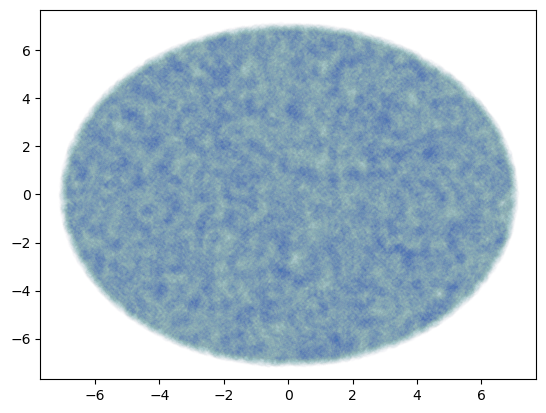

In [32]:
plt.scatter(df['true_core_x'].values,
            df['true_core_y'].values,
            alpha=0.008)
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.title('Scatter Plot Example')
plt.show()

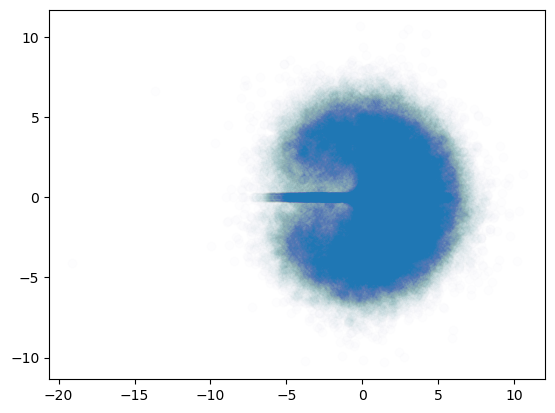

In [33]:
plt.scatter(df['muonefficiency_impact_x'].values,
            df['muonefficiency_impact_y'].values,
            alpha=0.008)
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.title('Scatter Plot Example')
plt.show()

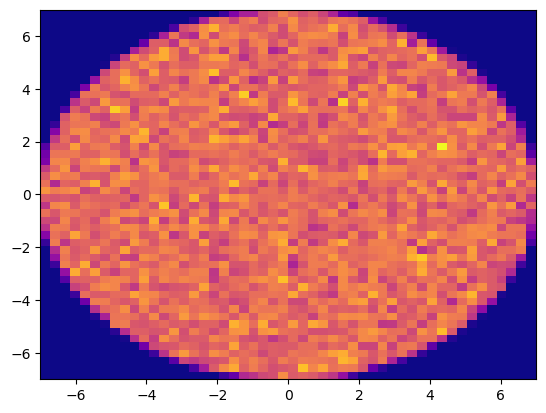

In [34]:
plt.hist2d(df['true_core_x'].values,
           df['true_core_y'].values,           
           bins=50,
           cmap='plasma')
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.title('Scatter Plot Example')
plt.show()

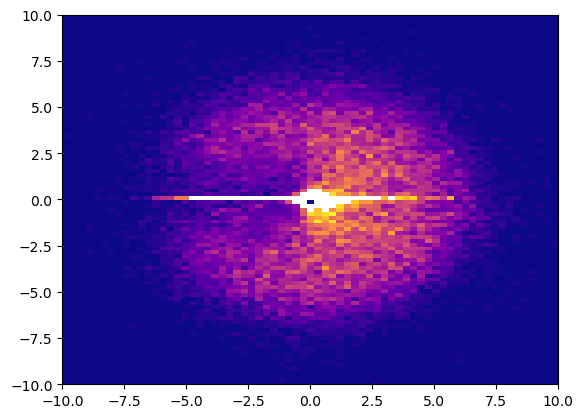

In [35]:
plt.hist2d(dfnna['muonefficiency_impact_x'].values,
           dfnna['muonefficiency_impact_y'].values,           
           bins=100,
           cmap='plasma',
           #norm=LogNorm(),
           cmin=0,
           cmax=50)
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
plt.xlim(-10,10)
plt.ylim(-10,10)
#plt.title('Scatter Plot Example')
plt.show()

<Axes: >

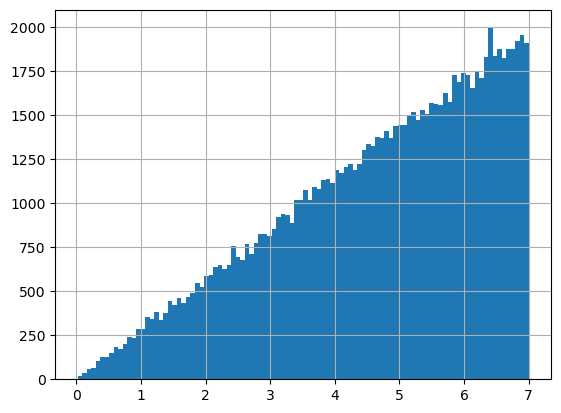

In [36]:
df['true_core_r'].hist(bins=100)

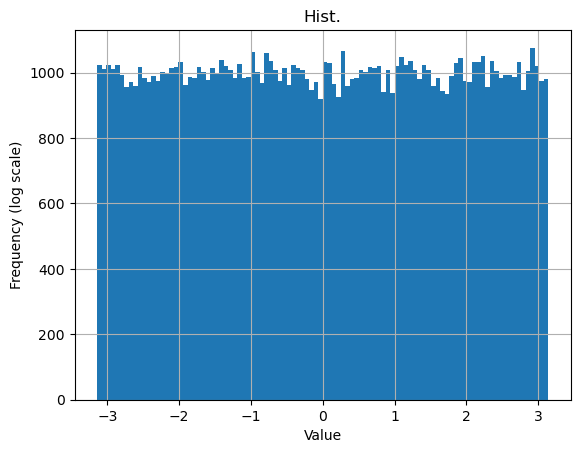

In [37]:
df['true_core_phi'].hist(bins=100)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(0.0,10)
#plt.ylim(0.0,300)

plt.show()

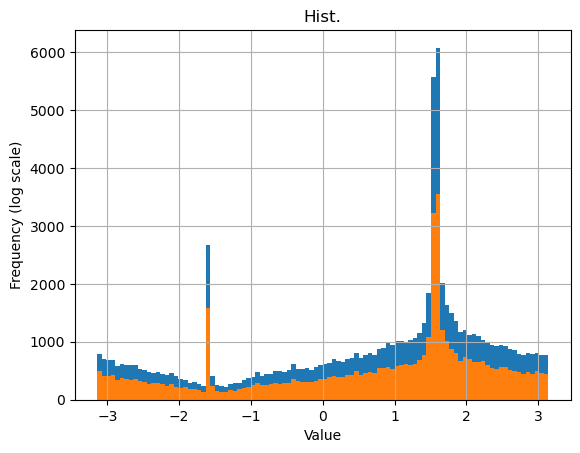

In [38]:
df['muonefficiency_impact_phi'].hist(bins=100)
dfnna['muonefficiency_impact_phi'].hist(bins=100)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(0.0,10)
#plt.ylim(0.0,300)

plt.show()

(array([ 490.,  401.,  403.,  424.,  338.,  371.,  363.,  349.,  355.,
         324.,  304.,  275.,  288.,  292.,  270.,  244.,  269.,  221.,
         205.,  213.,  179.,  177.,  176.,  130., 1580.,  238.,  149.,
         130.,  126.,  162.,  154.,  182.,  210.,  222.,  248.,  280.,
         251.,  262.,  264.,  285.,  277.,  293.,  288.,  366.,  318.,
         303.,  308.,  306.,  321.,  350.,  355.,  385.,  410.,  396.,
         384.,  423.,  423.,  491.,  424.,  462.,  484.,  468.,  542.,
         547.,  566.,  525.,  581.,  603.,  616.,  601.,  620.,  681.,
         777., 1091., 3225., 3542., 1202., 1005.,  868.,  806.,  670.,
         734.,  711.,  656.,  648.,  660.,  593.,  539.,  527.,  559.,
         564.,  516.,  492.,  475.,  450.,  473.,  451.,  502.,  463.,
         439.]),
 array([-1.79999484e+02, -1.76399491e+02, -1.72799497e+02, -1.69199504e+02,
        -1.65599511e+02, -1.61999518e+02, -1.58399525e+02, -1.54799532e+02,
        -1.51199539e+02, -1.47599546e+02, -1.43999

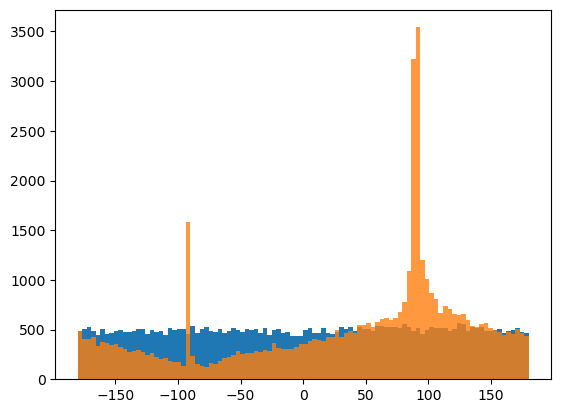

In [39]:
plt.hist(dfnna['true_core_phi'].values*180/np.pi, bins=100)
plt.hist(dfnna['muonefficiency_impact_phi'].values*180/np.pi,bins=100,alpha=0.8)


(array([488., 501., 526., 489., 448., 508., 458., 464., 481., 499., 472.,
        475., 487., 504., 509., 457., 499., 475., 490., 450., 517., 495.,
        506., 510., 451., 535., 469., 509., 531., 489., 478., 510., 461.,
        489., 515., 495., 472., 504., 491., 501., 463., 511., 448., 498.,
        510., 470., 477., 439., 439., 432., 491., 520., 467., 466., 519.,
        469., 458., 479., 523., 503., 525., 485., 531., 501., 510., 483.,
        533., 538., 530., 526., 523., 516., 553., 531., 481., 516., 454.,
        491., 527., 519., 518., 517., 489., 503., 568., 553., 487., 529.,
        520., 525., 489., 490., 497., 503., 466., 489., 494., 521., 477.,
        461.]),
 array([-1.79999350e+02, -1.76399372e+02, -1.72799395e+02, -1.69199417e+02,
        -1.65599439e+02, -1.61999462e+02, -1.58399484e+02, -1.54799506e+02,
        -1.51199529e+02, -1.47599551e+02, -1.43999574e+02, -1.40399596e+02,
        -1.36799618e+02, -1.33199641e+02, -1.29599663e+02, -1.25999685e+02,
        -1.223

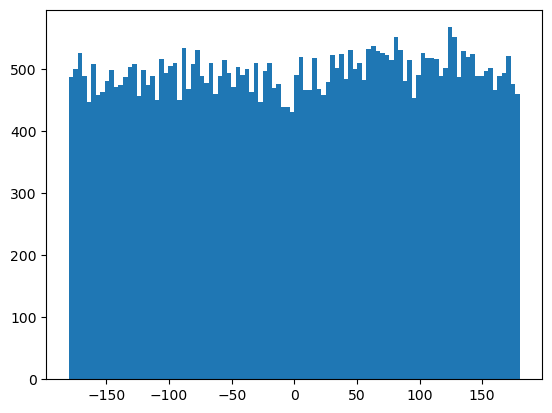

In [40]:
plt.hist(dfnna['true_core_phi'].values*180/np.pi, bins=100)

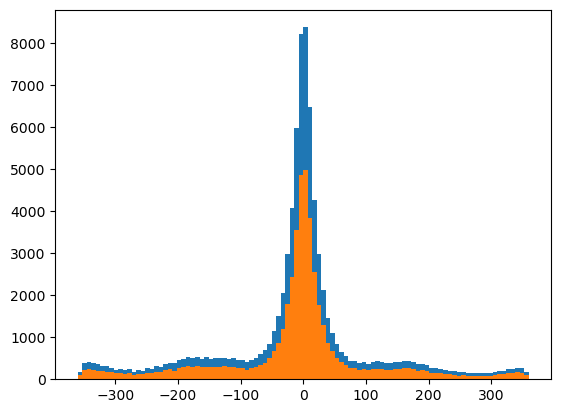

In [41]:
plt.hist(df['muonefficiency_impact_phi_rot'].values*180/np.pi - df['true_core_phi'].values*180/np.pi,
        bins=100)
plt.hist(dfnna['muonefficiency_impact_phi_rot'].values*180/np.pi - dfnna['true_core_phi'].values*180/np.pi,
        bins=100)
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.xlim(1,8)
#plt.title('Scatter Plot Example')
plt.show()

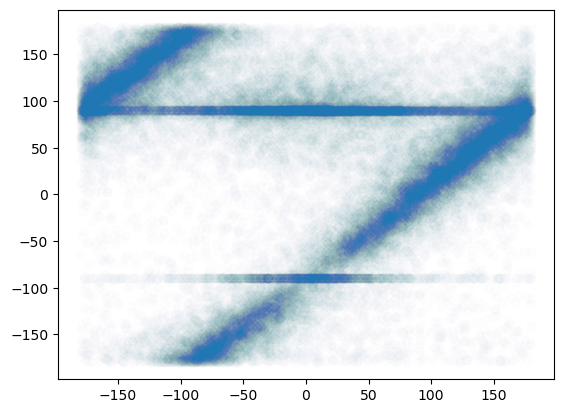

In [42]:
plt.scatter(dfnna['true_core_phi'].values*180/np.pi,
            dfnna['muonefficiency_impact_phi'].values*180/np.pi,
            alpha=0.008)
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.title('Scatter Plot Example')
plt.show()

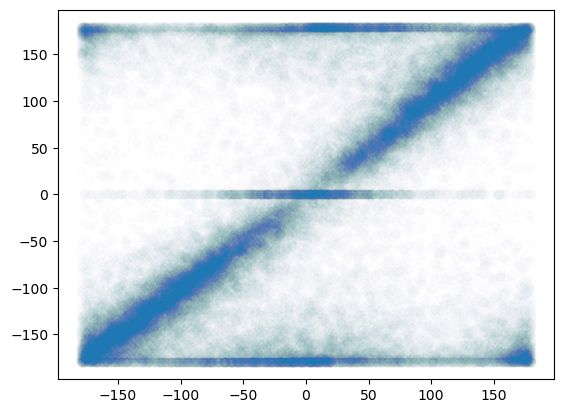

In [43]:
plt.scatter(dfnna['true_core_phi'].values*180/np.pi,
            dfnna['muonefficiency_impact_phi_rot'].values*180/np.pi,
            alpha=0.008)
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.title('Scatter Plot Example')
plt.show()

<Axes: >

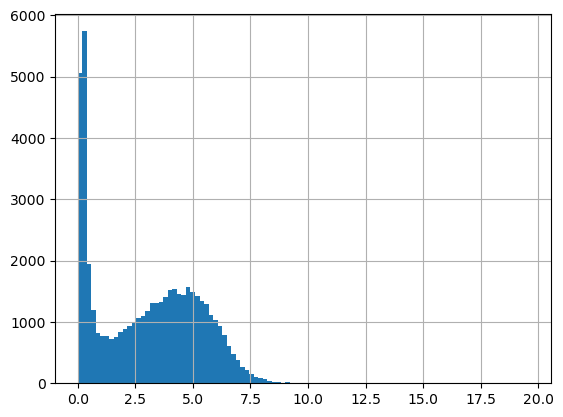

In [44]:
dfnna['muonefficiency_impact'].hist(bins=100)

<Axes: >

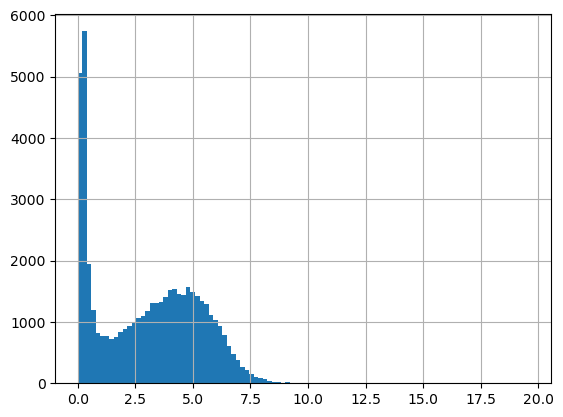

In [45]:
dfnna['muonefficiency_impact_r'].hist(bins=100)

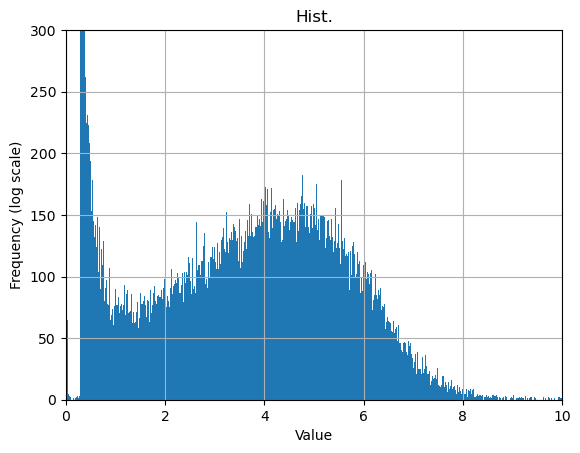

In [46]:
dfnna['muonefficiency_impact_r'].hist(bins=1000)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

plt.xlim(0.0,10)
plt.ylim(0.0,300)

plt.show()

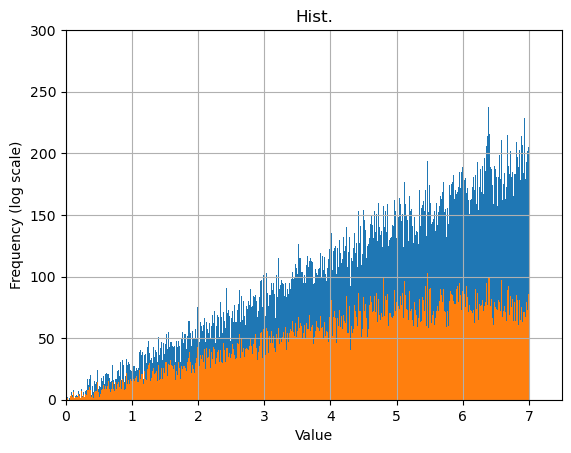

In [47]:
df['true_core_r'].hist(bins=1000)
dfnna['true_core_r'].hist(bins=1000)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

plt.xlim(0,7.5)
plt.ylim(0.0,300)

plt.show()

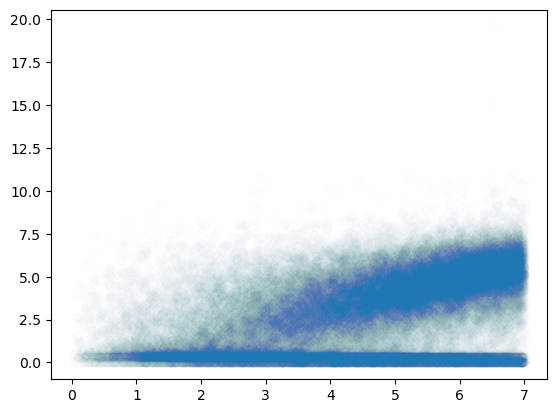

In [48]:
plt.scatter(dfnna['true_core_r'].values,
            dfnna['muonefficiency_impact_r'].values,
            alpha=0.008)
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.title('Scatter Plot Example')
plt.show()

In [49]:
dfnna_cut_tmp = dfnna[dfnna['true_core_r']>6]
dfnna_cut_tmp = dfnna_cut_tmp[dfnna_cut_tmp['true_core_r']<7]
dfnna_cut_tmp = dfnna_cut_tmp[dfnna_cut_tmp['muonefficiency_impact_r']>0.0]

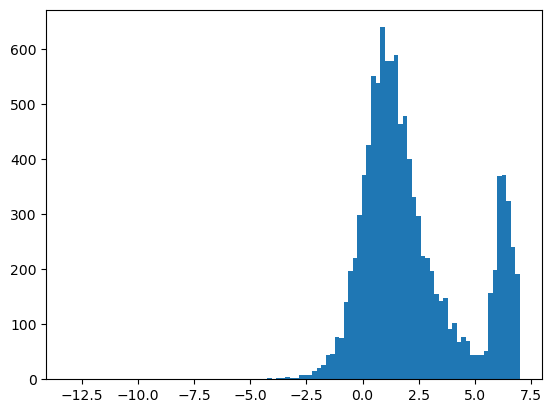

In [50]:
plt.hist(dfnna_cut_tmp['true_core_r'].values - dfnna_cut_tmp['muonefficiency_impact_r'].values,
        bins=100)
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.xlim(1,8)
#plt.title('Scatter Plot Example')
plt.show()

In [51]:
np.max(dfnna['muonefficiency_impact_r'].values - dfnna['muonefficiency_impact'].values)

np.float64(1.7763568394002505e-15)

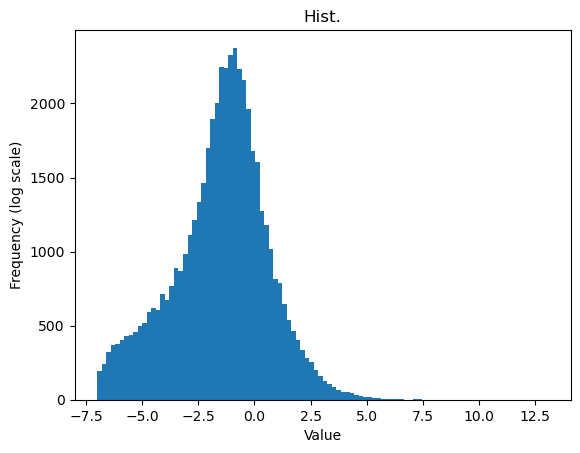

In [52]:
plt.hist(dfnna['muonefficiency_impact_r'].values - dfnna['true_core_r'].values,
         bins=100)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

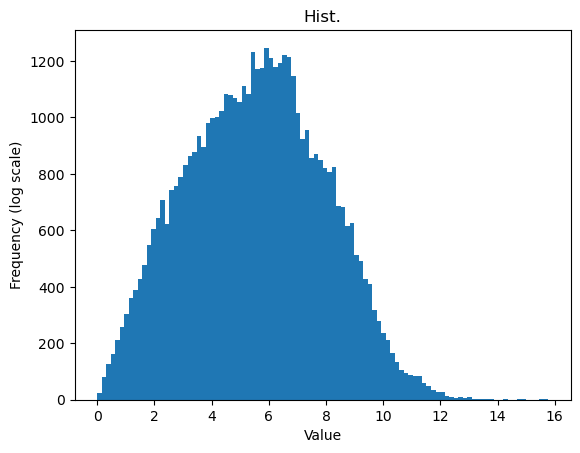

In [53]:
plt.hist(dfnna['muonefficiency_impact_delta'].values,bins=100)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

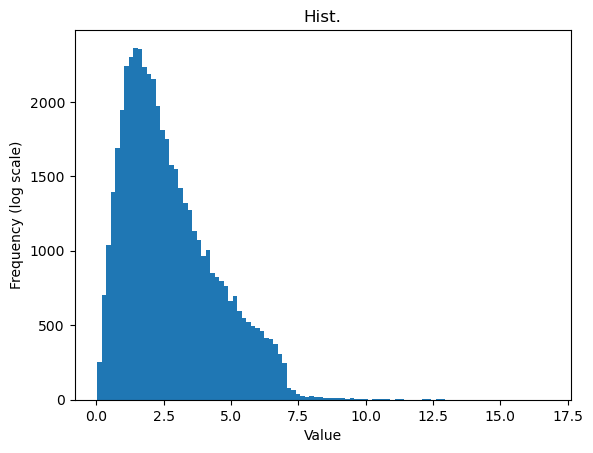

In [54]:
plt.hist(dfnna['muonefficiency_impact_delta_rot'].values,bins=100)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

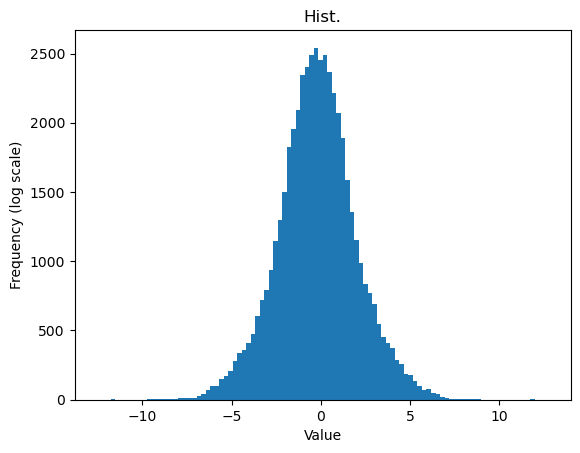

In [55]:
plt.hist(dfnna['muonefficiency_impact_x_rot'].values - dfnna['true_core_x'].values,bins=100)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

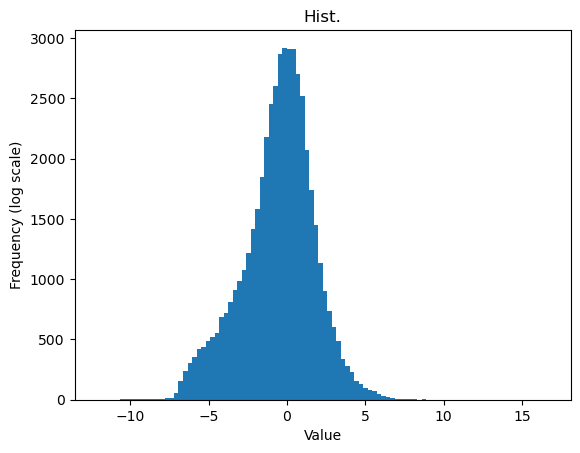

In [56]:
plt.hist(dfnna['muonefficiency_impact_y_rot'].values - dfnna['true_core_y'].values,bins=100)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

In [57]:
dfnna_cut=dfnna[dfnna['muonefficiency_impact_delta']<2.0]

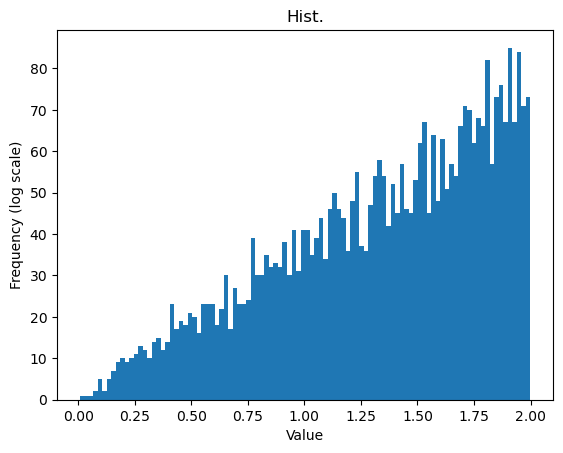

In [58]:
plt.hist(dfnna_cut['muonefficiency_impact_delta'].values,bins=100)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

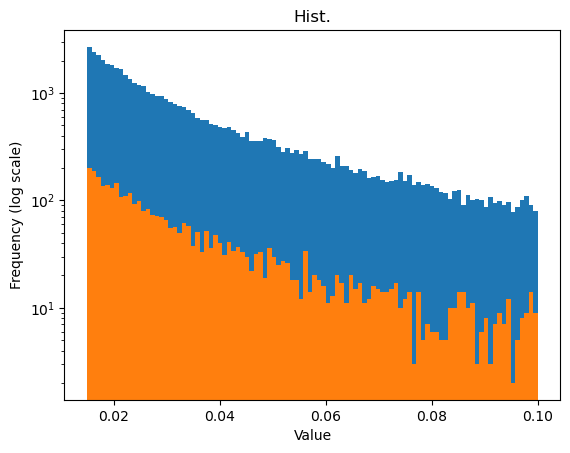

In [59]:
plt.hist(dfnna['true_energy'].values,bins=100)
plt.hist(dfnna_cut['true_energy'].values,bins=100)

plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

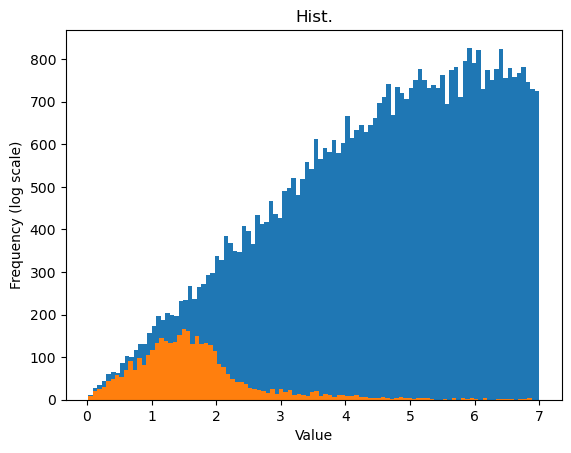

In [60]:
plt.hist(dfnna['true_core_r'].values,bins=100)
plt.hist(dfnna_cut['true_core_r'].values,bins=100)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

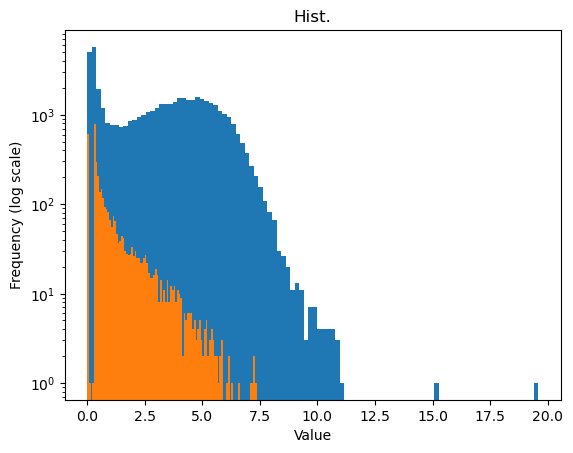

In [61]:
plt.hist(dfnna['muonefficiency_impact_r'].values,bins=100)
plt.hist(dfnna_cut['muonefficiency_impact_r'].values,bins=100)

plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

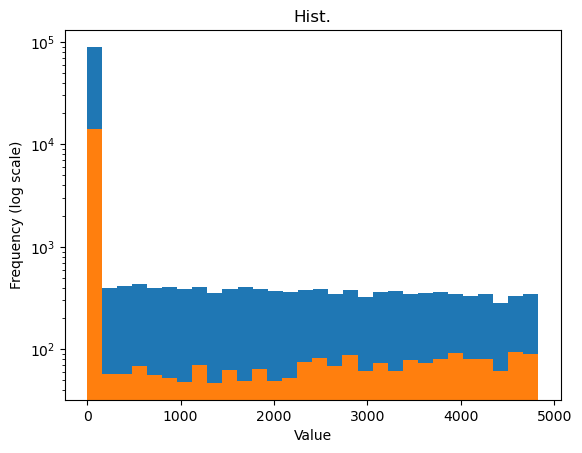

In [62]:
plt.hist(df['true_h_first_int'].values, bins=30)
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

plt.hist(df[df['muonefficiency_impact'].isna()]['true_h_first_int'].values, bins=30)
#plt.yscale('log')  # Set y-axis to log scale
#plt.xlabel('Value')
#plt.ylabel('Frequency (log scale)')
#plt.title('Hist.')
#plt.show()

plt.show()

In [63]:
df[df['muonefficiency_impact'].isna()]['true_h_first_int'].values

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       1.00000000e+00, 1.00000000e+00, 4.01942432e+03])

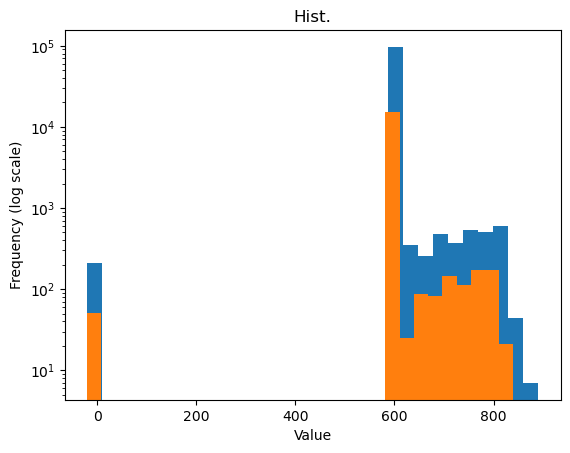

In [64]:
plt.hist(df['true_x_max'].values, bins=30)

plt.hist(df[df['muonefficiency_impact'].isna()]['true_x_max'].values, bins=30)


plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')
plt.show()

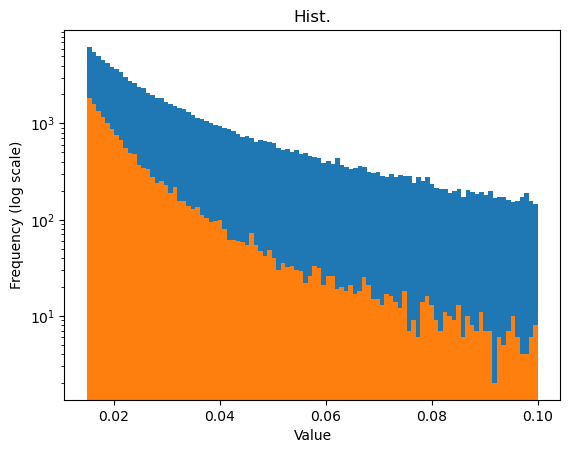

In [65]:
plt.hist(df['true_energy'].values, bins=100)

plt.hist(df[df['muonefficiency_impact'].isna()]['true_energy'].values, bins=100)


plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')
plt.show()

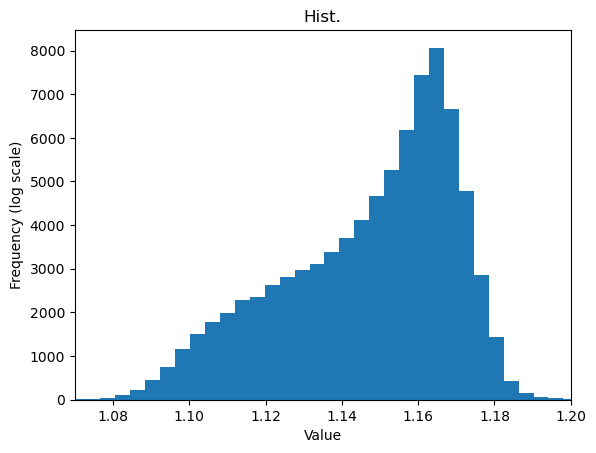

In [66]:
plt.hist(df[~df['muonring_radius'].isna()]['muonring_radius'].values, bins=1000)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

plt.xlim(1.07,1.2)

plt.show()

In [67]:
df['true_gamma'] = df['true_energy'].apply(lambda x: (x+0.0001056583755)/0.0001056583755)

In [68]:
df['true_betta'] = df['true_gamma'].apply(lambda x: np.sqrt(1.0 - 1.0/x/x))

In [69]:
df['expected_muonring_radius'] = df['true_betta'].apply(lambda x: np.acos(1.0/x/1.00021)*180.0/np.pi)

<Axes: >

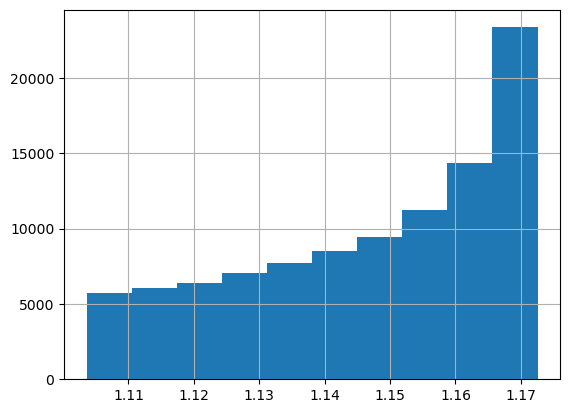

In [70]:
df['expected_muonring_radius'].hist()

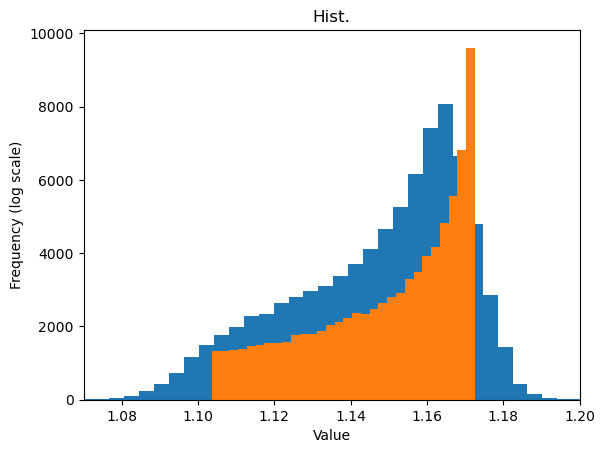

In [71]:
plt.hist(df[~df['muonring_radius'].isna()]['muonring_radius'].values, bins=1000)
plt.hist(df[~df['muonring_radius'].isna()]['expected_muonring_radius'].values, bins=30)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

plt.xlim(1.07,1.2)

plt.show()

In [72]:
dfc=df[df['true_energy']>0.07]

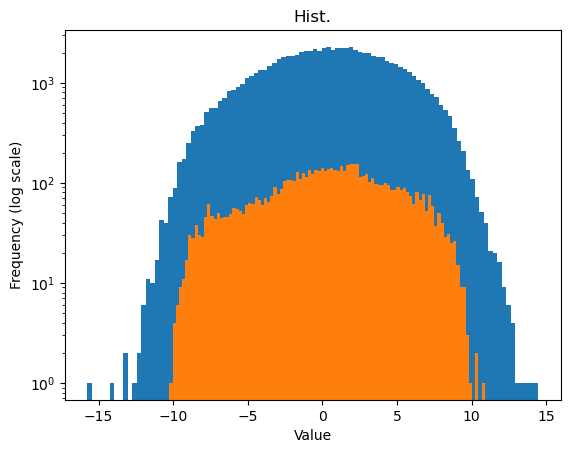

In [73]:
plt.hist(df[~df['muonefficiency_impact_x'].isna()]['muonefficiency_impact_x'].values - df[~df['muonefficiency_impact_x'].isna()]['true_core_x'].values,
         bins=100)

plt.hist(dfc[~dfc['muonefficiency_impact_x'].isna()]['muonefficiency_impact_x'].values - dfc[~dfc['muonefficiency_impact_x'].isna()]['true_core_x'].values,
         bins=100)


plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

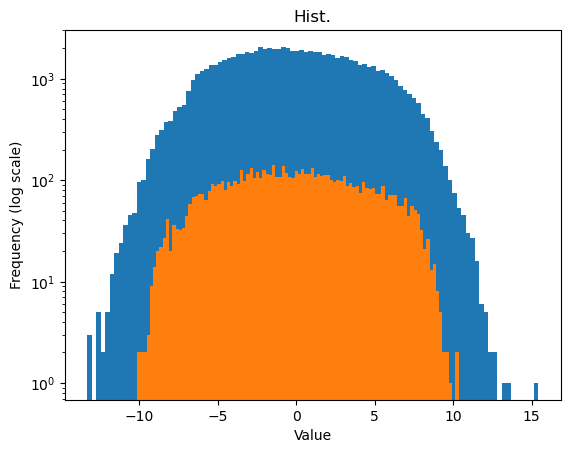

In [74]:
plt.hist(df[~df['muonefficiency_impact_y'].isna()]['muonefficiency_impact_y'].values - df[~df['muonefficiency_impact_y'].isna()]['true_core_y'].values,
         bins=100)

plt.hist(dfc[~dfc['muonefficiency_impact_y'].isna()]['muonefficiency_impact_y'].values - dfc[~dfc['muonefficiency_impact_y'].isna()]['true_core_y'].values,
         bins=100)


plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

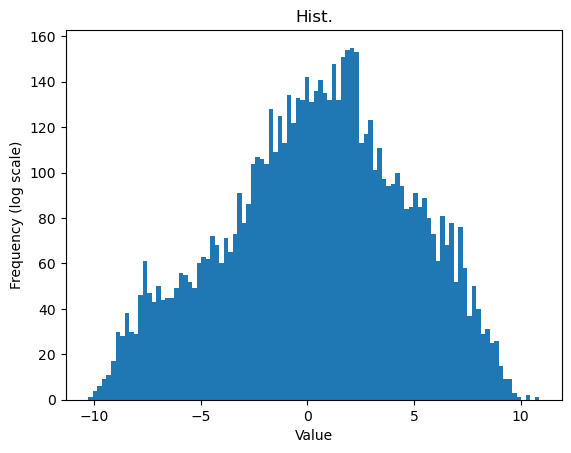

In [75]:
plt.hist(dfc[~dfc['muonefficiency_impact_x'].isna()]['muonefficiency_impact_x'].values - dfc[~dfc['muonefficiency_impact_x'].isna()]['true_core_x'].values,
         bins=100)


#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

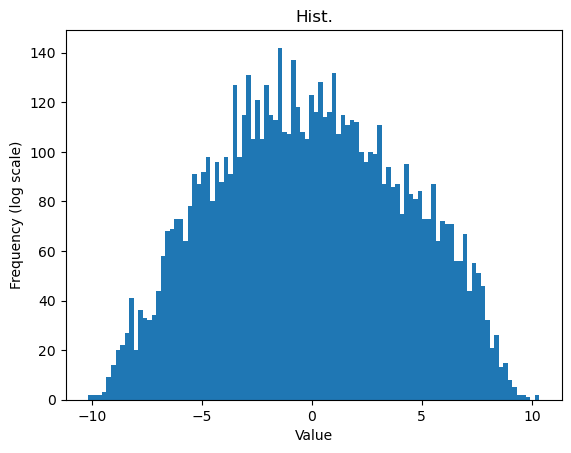

In [76]:
plt.hist(dfc[~dfc['muonefficiency_impact_y'].isna()]['muonefficiency_impact_y'].values - dfc[~dfc['muonefficiency_impact_y'].isna()]['true_core_y'].values,
         bins=100)


#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

#plt.xlim(-0.025,0.025)

plt.show()

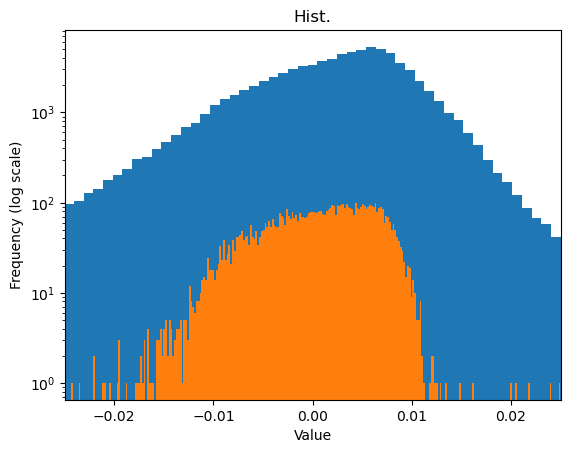

In [77]:
plt.hist(-df[~df['muonring_radius'].isna()]['muonring_radius'].values + df[~df['muonring_radius'].isna()]['expected_muonring_radius'].values,
         bins=4000)

plt.hist(-dfc[~dfc['muonring_radius'].isna()]['muonring_radius'].values + dfc[~dfc['muonring_radius'].isna()]['expected_muonring_radius'].values,
         bins=4000)


plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

plt.xlim(-0.025,0.025)

plt.show()

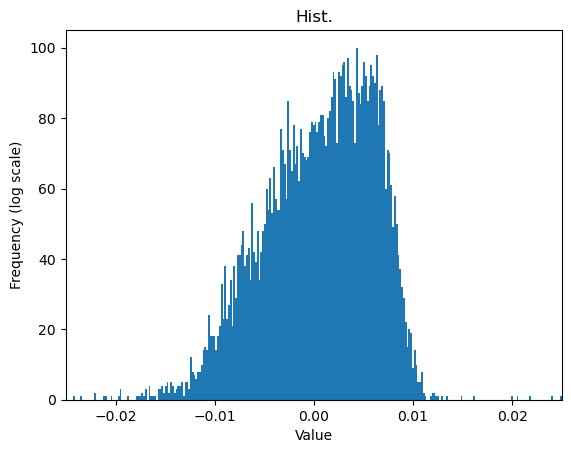

In [78]:
plt.hist(-dfc[~dfc['muonring_radius'].isna()]['muonring_radius'].values + dfc[~dfc['muonring_radius'].isna()]['expected_muonring_radius'].values,
         bins=4000)


#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

plt.xlim(-0.025,0.025)

plt.show()

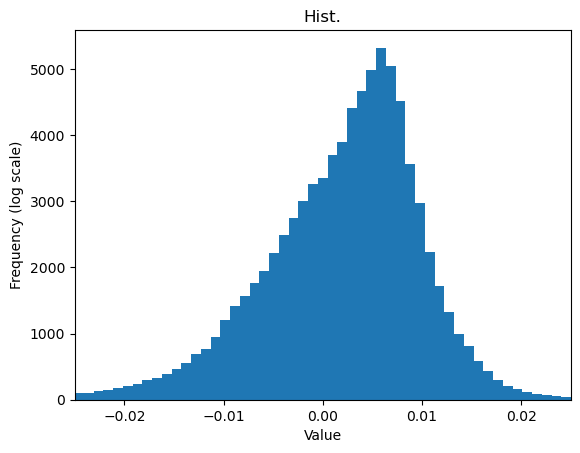

In [79]:
plt.hist(-df[~df['muonring_radius'].isna()]['muonring_radius'].values + df[~df['muonring_radius'].isna()]['expected_muonring_radius'].values,
         bins=4000)

#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Hist.')

plt.xlim(-0.025,0.025)

plt.show()

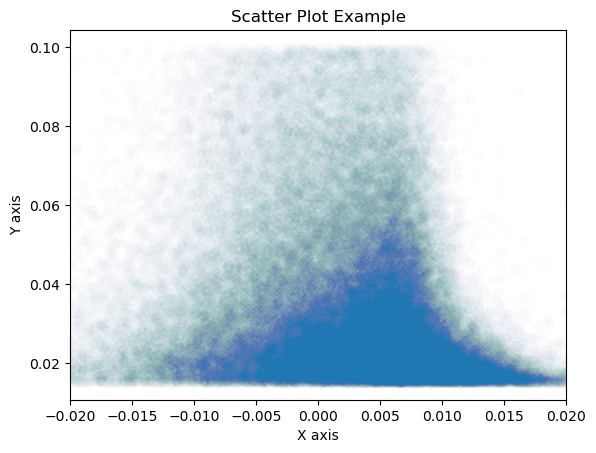

In [80]:
plt.scatter(-df[~df['muonring_radius'].isna()]['muonring_radius'].values + df[~df['muonring_radius'].isna()]['expected_muonring_radius'].values,
            df[~df['muonring_radius'].isna()]['true_energy'].values,
            alpha=0.008)
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.xlim(-0.02,0.02)
plt.title('Scatter Plot Example')
plt.show()